## 森田研究室 33B21009 羽田充宏

## 課題13-1 hmmlearnを用いてdata.csvからHMMを学習する

In [1]:
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
from graphviz import Digraph
np.random.seed(42)
rn = 42 # random_state

In [2]:
X = np.loadtxt('data.csv',delimiter = ',')

In [3]:
X.shape

(1000, 2)

In [4]:
X[:10]

array([[ 2.59096539,  0.13559196],
       [ 1.72217017,  0.5289679 ],
       [ 1.84197462, -0.21819851],
       [ 4.37844612, 10.34393468],
       [ 7.59912621,  0.18687707],
       [ 5.75057235,  8.41670982],
       [ 7.67935418, -1.4621948 ],
       [-0.67642954,  8.03447793],
       [10.00703962,  7.58858762],
       [ 1.64141978, -0.57665958]])

上のデータは二次元ガウス分布に従って出力されたものである．  
また各ステップ(合計1000)でサンプルデータの従う正規分布の平均値$\mu$は異なっており，潜在変数となっている．  
学習では観測データから潜在変数の数と値，潜在変数間の遷移確率およびグラフ構造を推定することが目的となっている．  
前提として遷移確率は$p \in \{0, 0.1, ..., 1.0\}$であり，ガウス分布の平均は$\mu \in \{0, 1, ..., 10\}$であり，分散は一定の値となっている．

注) 「ガウス分布の分散は一定に設定した」 -> 正規分布は対角成分は一定値$\sigma^2 \in \mathbb{R}$で非対角成分0という認識です．

以下では学習コードについて説明を行う．  
今回は二次元ガウス分布について扱うのでGaussianHMMクラスを利用する．  
一旦，潜在変数のノード数は3であるという過程のもとで実験を行う

In [5]:
model = hmm.GaussianHMM(n_components=3, covariance_type="spherical", n_iter = 100, random_state=rn)

In [6]:
model.fit(X)

GaussianHMM(covariance_type='spherical', n_components=3, n_iter=100,
            random_state=42)

学習の結果得られた結果は以下のようになる．  
- 状態遷移行列

In [7]:
model.transmat_

array([[0.42470855, 0.39036077, 0.18493068],
       [0.54055348, 0.31939533, 0.14005118],
       [0.40988581, 0.23015116, 0.35996303]])

- 潜在変数(初期値確率)

In [8]:
model.startprob_

array([1.00000000e+00, 2.00293234e-20, 2.45085491e-71])

- 潜在変数(平均値) $\mu$

In [9]:
model.means_

array([[5.63163448, 0.07154086],
       [7.3680374 , 8.49197651],
       [0.0579629 , 7.02950248]])

- 潜在変数(共分散行列) $\Sigma$ 

In [10]:
model.covars_

array([[[[5.12454504, 0.        ],
         [0.        , 5.12454504]]],


       [[[5.11709333, 0.        ],
         [0.        , 5.11709333]]],


       [[[0.53984036, 0.        ],
         [0.        , 0.53984036]]]])

また，学習データが得られた際の潜在変数の推移の予測値は以下のようになる

In [11]:
model.predict(X)[:10] # 本当は1000次元データだが最初の10個を表示

array([0, 0, 0, 1, 0, 1, 0, 2, 1, 0], dtype=int32)

また今回得られたパラメータに対してのモデルの当てはまりの良さを表す尤度は以下のような値となる(厳密には対数尤度 -> 値が大きいほど当てはまりが良い)

In [12]:
model.score(X)

-5010.36972777804

上の尤度の値がどれくらい良いかは絶対値としての評価はできないがこの値をベースラインとして以下ではさらに改良した推定を行っていく

## 課題13-2 作成したプログラムを用いてdata.csvを生成した元のHMMの隠れ状態数，グラフ構造，遷移確率を推定

上での推定方法にはいくつかの問題点が存在する．  
まず，今回は共分散行列の非対角成分が0，さらに全ての潜在変数に対して同じ値を共有する制約を課したいが，ライブラリの都合上そのような処理は実現できない．  
しかしながら上での結果を見るとどのノードも大体5.1付近に値が集中しているので得られた結果の平均値を予測値として利用しても問題ないと考えられる．  
また，fitメソッドでの学習においては潜在変数の数はハイパーパラメータであるのでこちら側で調整する必要がある．  
ここで潜在変数の数を多くすることはモデルの自由度を上げることに相当するので，潜在変数の数の増加に伴って対数尤度の値は改善していくことが期待できる．  
実際したのグラフのように潜在変数の数を増やせば増やすほど目的関数(対数尤度)の値は大きくなり，潜在変数の数が5を超えたあたりで飽和していることが見て取れる．  

In [13]:
res = [hmm.GaussianHMM(n_components=i, covariance_type="spherical", n_iter = 100, random_state=rn).fit(X).score(X) for i in range(1,11)]

Text(0, 0.5, 'log likelihood')

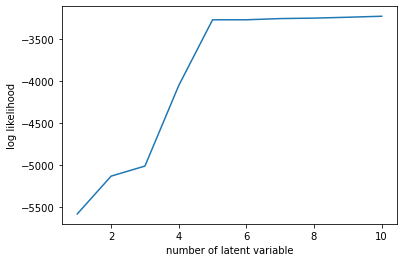

In [14]:
plt.plot(range(1,11), res)
plt.xlabel("number of latent variable")
plt.ylabel("log likelihood")

現実的にはAICなどの情報量基準を考慮して最適化したりする必要があるが，今回は上の結果がグリッドサーチした結果だと思って潜在変数の数は5であると決め打ちすることとする．  
最後の問題としては今回は平均値$\mu$と遷移確率$p$が離散値をとる制約が課されているがhmmlearnの学習では離散変数の制約を入れることができない．  
そこで平均値と遷移確率をハイパーパラメータだと思ってoptunaやグリッドサーチで最適化するなどの手法が考えられるが今回はhmmで得られた値を丸めることで制約を満たす解を得ることとする．  
他に潜在変数の数が1や2ならば全探索をするなどの手法が考えれるが，今回は潜在変数の数を5としたので厳しい（潜在変数の数に対して計算量が指数時間であるため）

以上を踏まえて以下では得られたデータの生成モデルを推定する

In [15]:
model = hmm.GaussianHMM(n_components=5, covariance_type="spherical", n_iter = 100, random_state=rn)

In [16]:
model.fit(X)

GaussianHMM(covariance_type='spherical', n_components=5, n_iter=100,
            random_state=42)

In [17]:
model.score(X)

-3266.6063090134094

以上より問題の制約を満たした推定値は以下のようになる

- 状態遷移行列

In [18]:
transmat = (model.transmat_ // 0.1) * 0.1
for c in transmat:
    c[np.argmax(c)] += 1 - c.sum()
print(transmat)

[[0.4 0.3 0.3 0.  0. ]
 [0.6 0.1 0.  0.3 0. ]
 [0.5 0.  0.3 0.  0.2]
 [0.  0.3 0.  0.6 0.1]
 [0.  0.  0.2 0.2 0.6]]


- 初期確率

In [19]:
startprob = model.startprob_
print(startprob)

[7.04865002e-082 5.10990511e-123 4.93304098e-100 1.00000000e+000
 9.34766714e-136]


- 平均値

In [20]:
means = model.means_ // 1
print(means)

[[ 8.  0.]
 [ 4.  9.]
 [ 0.  7.]
 [ 1.  0.]
 [10.  6.]]


- 共分散行列

In [21]:
m = np.mean([x[0][0][0] for x in model.covars_])
covars = (np.zeros_like(model.covars_) + np.diag([m,m])).reshape(5,2,2)
print(covars)

[[[0.53809358 0.        ]
  [0.         0.53809358]]

 [[0.53809358 0.        ]
  [0.         0.53809358]]

 [[0.53809358 0.        ]
  [0.         0.53809358]]

 [[0.53809358 0.        ]
  [0.         0.53809358]]

 [[0.53809358 0.        ]
  [0.         0.53809358]]]


以上が推定値となる．  
また，この推定値のもとで対数尤度は以下のようになる

In [22]:
model = hmm.GaussianHMM(n_components=5, covariance_type="full", n_iter = 100, random_state=rn)
model.startprob_ = startprob
model.transmat_ = transmat
model.means_ = means
model.covars_ = covars + 1e-8
model.score(X)

-3864.145858910657

上の対数尤度の値は遷移行列，平均値をそれぞれの丸めた分，元の対数尤度よりも値が悪化しているが上で見たベースラインのモデルと比較するとだいぶ改善されていることがわかる．  

以下は遷移図を表す

In [23]:
pos = [means[i].tolist() for i in range(5)]

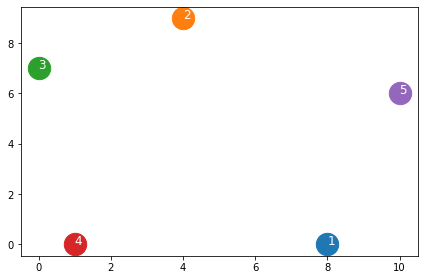

In [24]:
idx = 1
for p in pos:
    plt.scatter(p[0], p[1], s = 500)
    plt.annotate(f"{idx}", xy = (p[0],p[1]), fontsize = 12, c = 'w')
    idx+=1
plt.tight_layout()